# 1. Introducción:

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.
El objetivo de este proyecto es crear un modelo el para predecir si un cliente dejará el banco pronto, con un valor F1 de al menos 0.59.

# 2. Descripción de los datos:

Puedes encontrar los datos en el archivo `/datasets/Churn.csv`. Descarga el conjunto de datos.

**Características:**

- **RowNumber**: Índice de cadena de datos.
- **CustomerId**: Identificador de cliente único.
- **Surname**: Apellido.
- **CreditScore**: Valor de crédito.
- **Geography**: País de residencia.
- **Gender**: Sexo.
- **Age**: Edad.
- **Tenure**: Período durante el cual ha madurado el depósito a plazo fijo de un cliente (años).
- **Balance**: Saldo de la cuenta.
- **NumOfProducts**: Número de productos bancarios utilizados por el cliente.
- **HasCrCard**: El cliente tiene una tarjeta de crédito (1 - sí; 0 - no).
- **IsActiveMember**: Actividad del cliente (1 - sí; 0 - no).
- **EstimatedSalary**: Salario estimado.

**Objetivo:**
- **Exited**: El cliente se ha ido (1 - sí; 0 - no).

# 1° Analisis de los datos :

In [1]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el preprocesamiento y modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Bibliotecas para modelado y evaluación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import resample

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
# Mostrar las primeras filas del conjunto de datos
print(data.head())

# Verificar la estructura general del conjunto de datos
print(data.info())

# Resumen estadístico de las columnas numéricas
print(data.describe())

# Comprobar valores únicos en características categóricas
print(data['Geography'].value_counts())
print(data['Gender'].value_counts())

# Inspeccionar el balance de clases en la variable objetivo
print(data['Exited'].value_counts(normalize=True))


   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

# 2° Preparación de los datos

In [4]:
# Eliminar columnas irrelevantes ya que estas columnas son variables para identificar al cliente y no aportan un valor como tal para identificar si el ciente se va o no
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# La columna Tunure tiene valores nulos por lo que se usara la media para imputar estos valores
data['Tenure'].fillna(data['Tenure'].median(), inplace=True)

# Hay columnas categoricas las cuales hay que cambair a variables numericas.
data = pd.get_dummies(data, columns=['Geography', 'Gender'], drop_first=True)

# Escalamiento de características numéricas
scaler = StandardScaler()
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# 3° EDA (Analisis Exploratorio de Datos)

<Figure size 1000x600 with 0 Axes>

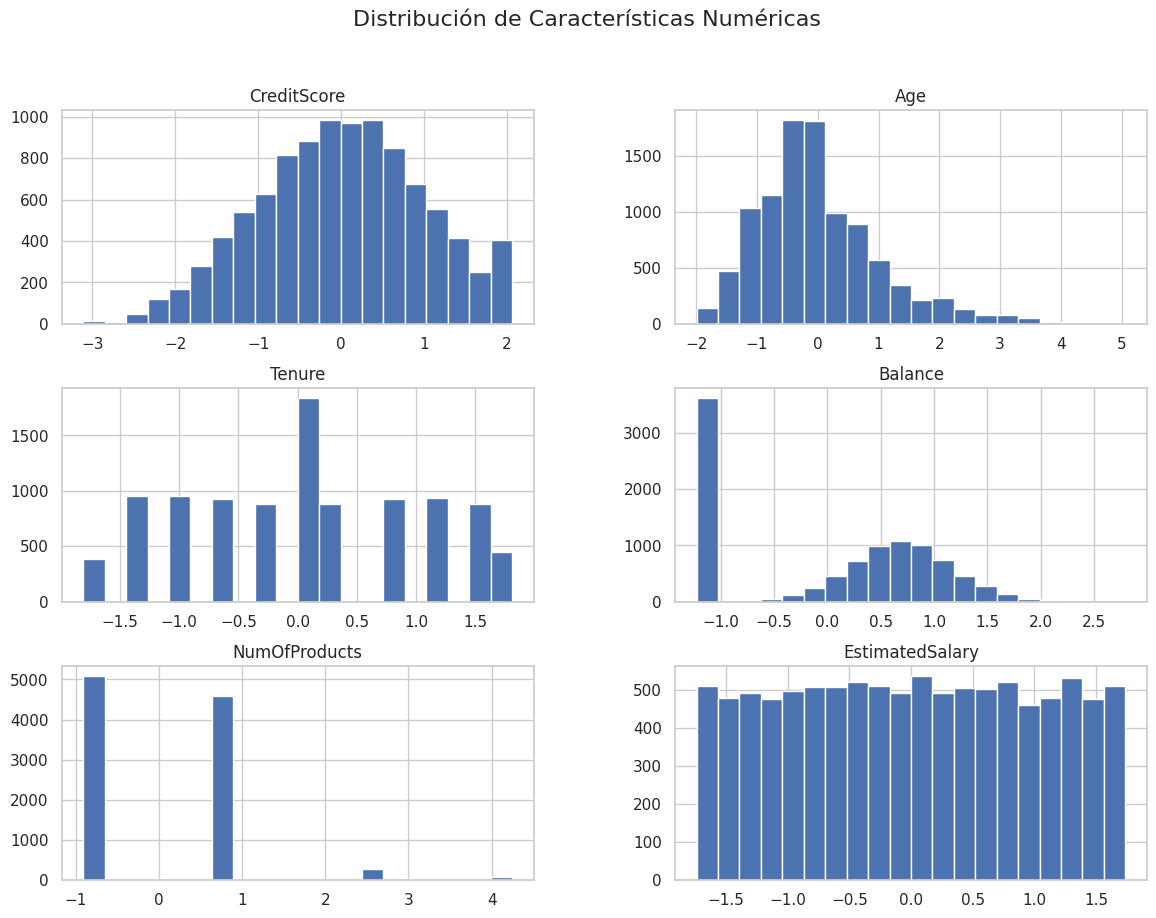

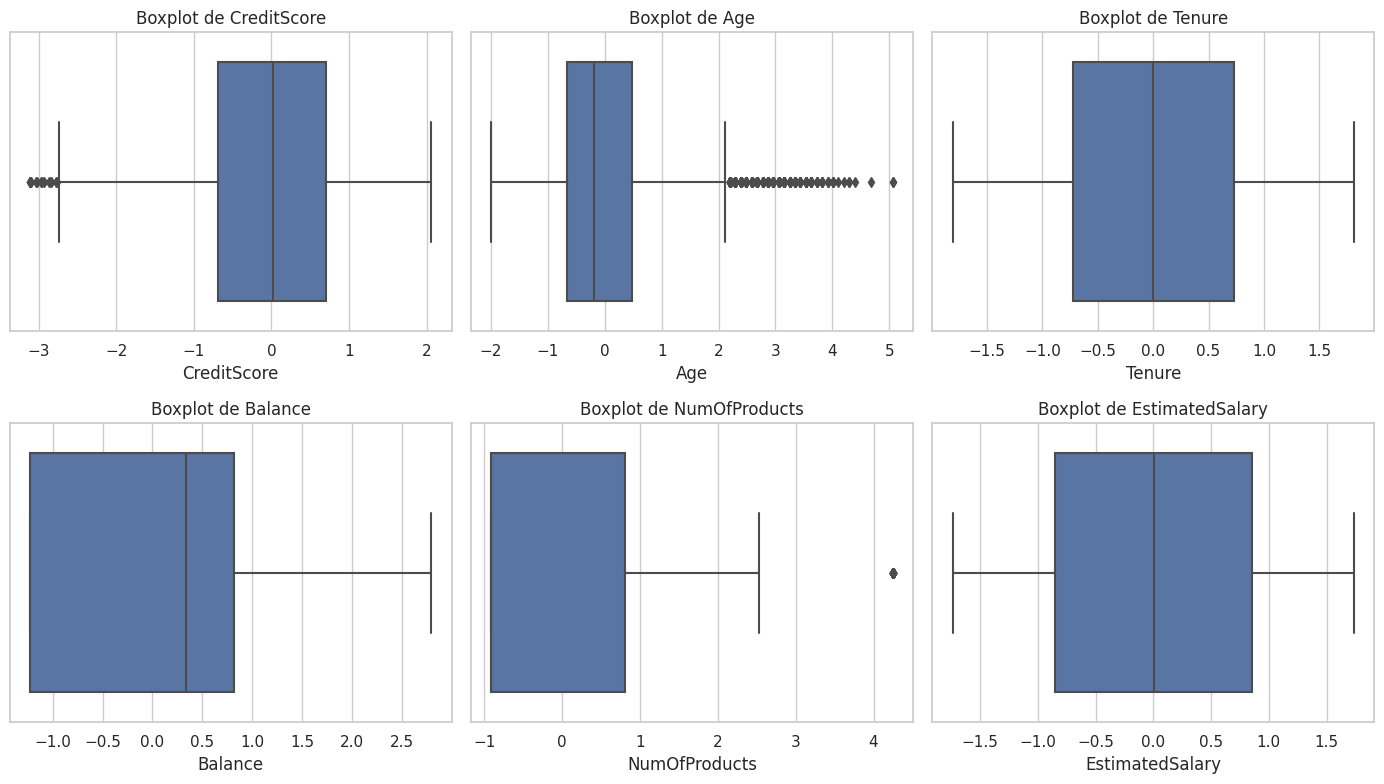

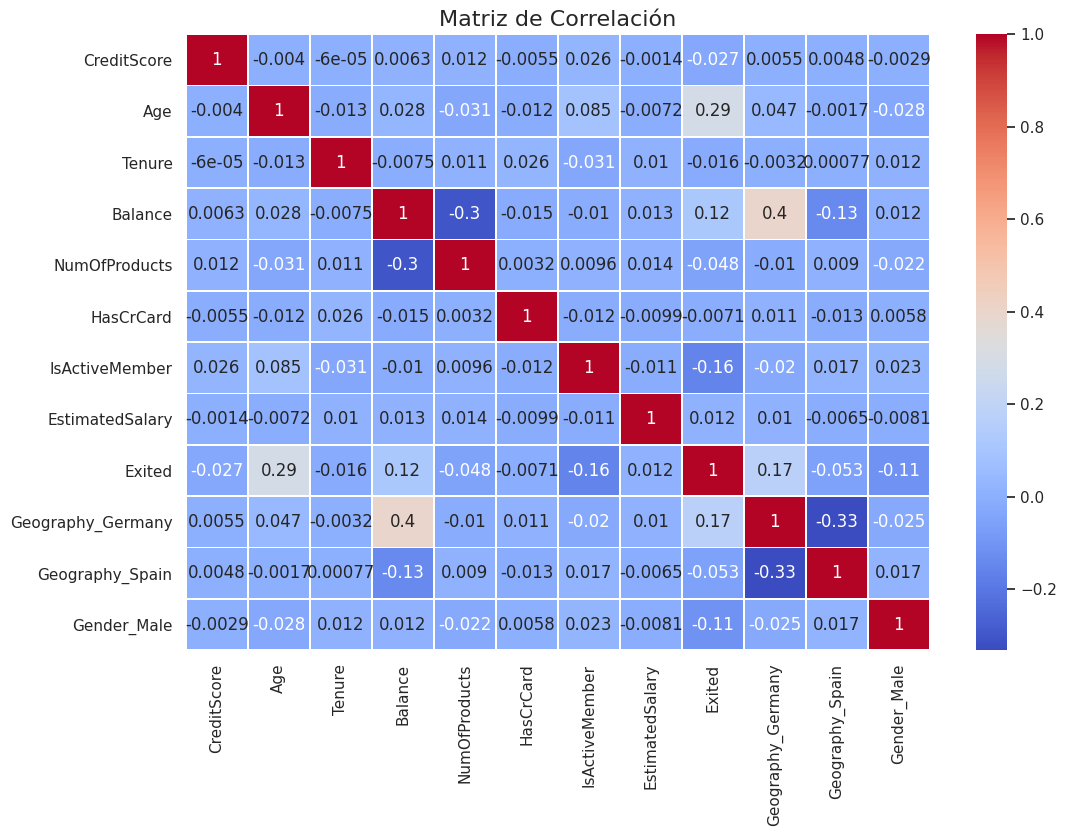

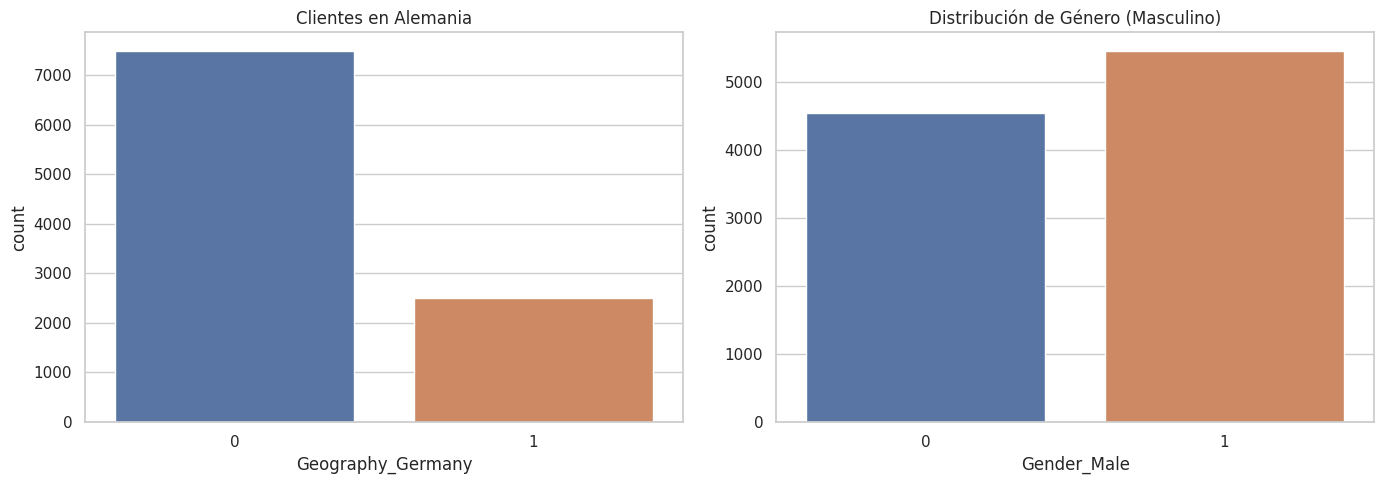

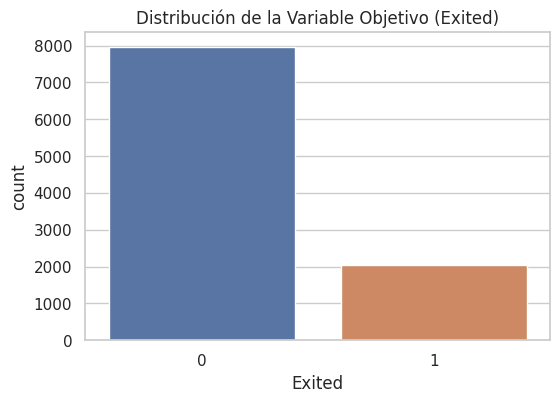

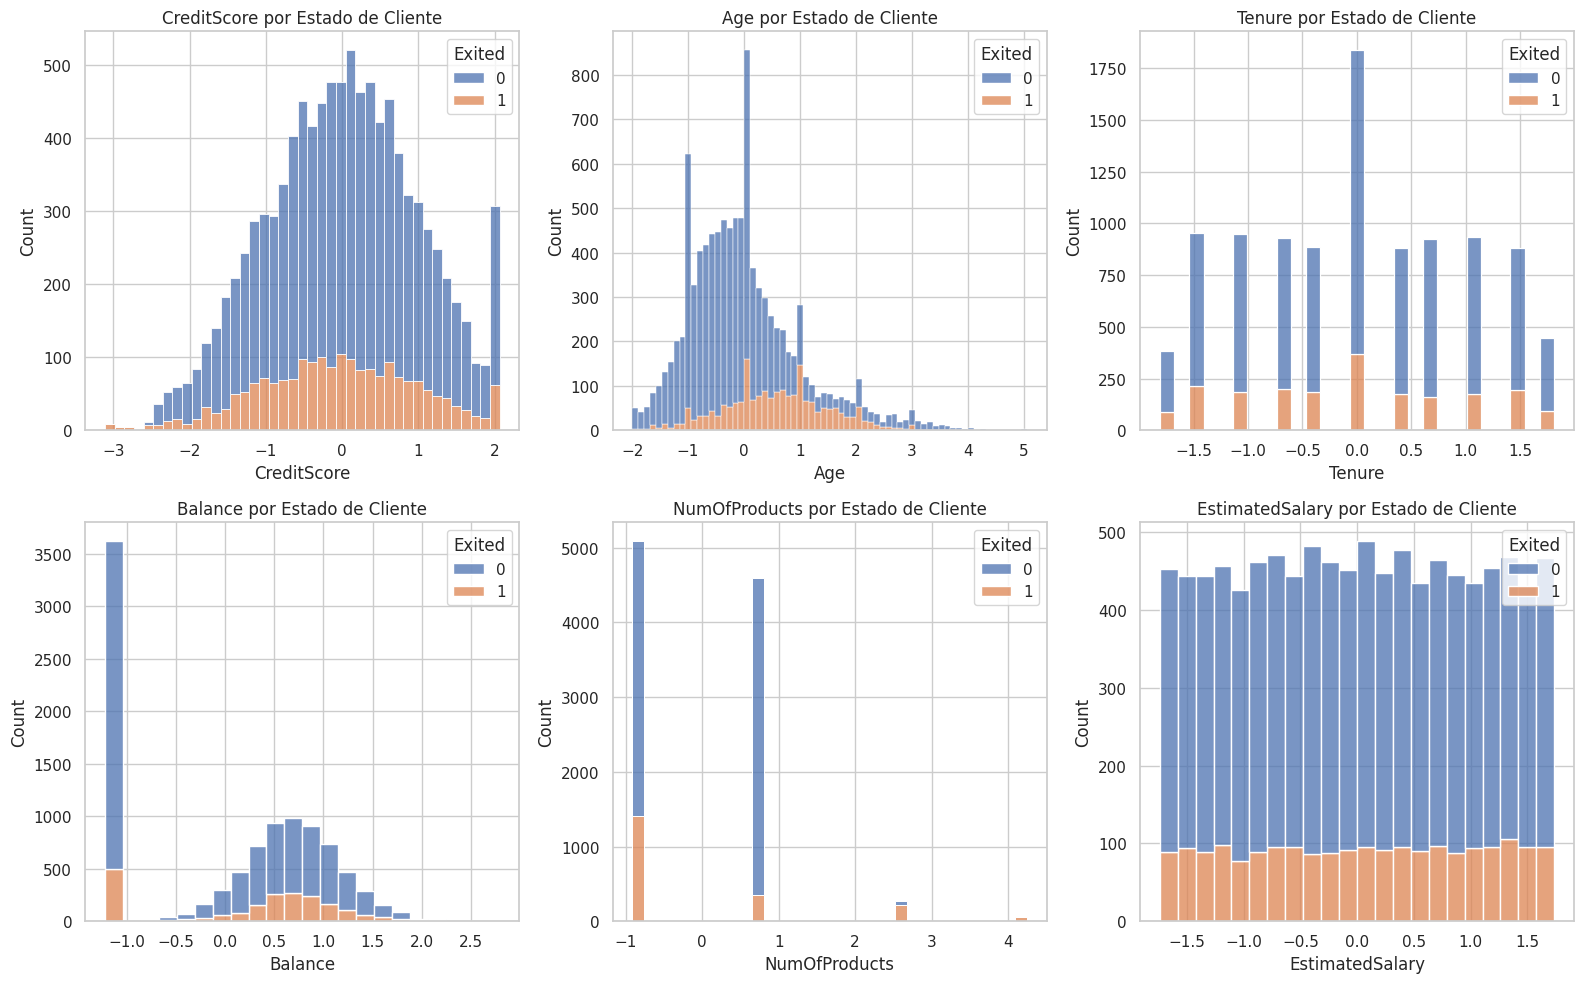

In [5]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

# 1. Histogramas para las características numéricas
data[numerical_features].hist(bins=20, figsize=(14, 10))
plt.suptitle('Distribución de Características Numéricas', fontsize=16)
plt.show()

# 2. Boxplots para detectar valores atípicos
plt.figure(figsize=(14, 8))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot de {feature}')
plt.tight_layout()
plt.show()

# 3. Matriz de correlación
plt.figure(figsize=(12, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

# 4. Distribución de las características categóricas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x='Geography_Germany', data=data, ax=axes[0])
axes[0].set_title('Clientes en Alemania')
sns.countplot(x='Gender_Male', data=data, ax=axes[1])
axes[1].set_title('Distribución de Género (Masculino)')
plt.tight_layout()
plt.show()

# 5. Distribución de la variable objetivo
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=data)
plt.title('Distribución de la Variable Objetivo (Exited)')
plt.show()

# 6. Comparación de características importantes por clase
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for i, feature in enumerate(numerical_features):
    sns.histplot(data=data, x=feature, hue='Exited', multiple='stack', ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'{feature} por Estado de Cliente')
plt.tight_layout()
plt.show()

# 4° Entrenamiento del modelo sin tratar el desequilibrio de clases

In [6]:
# Separar características y objetivo
features = data.drop('Exited', axis=1)
target = data['Exited']

# Divición del conjunto de datos en entrenamiento y prueba (75% - 25%)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

# Entrenar un modelo de Regresión Logística (sin tratar el desequilibrio de clases)
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)

# Predicciones en el conjunto de prueba
predicted_valid = model.predict(features_valid)

#Calculo de as métricas F1 y AUC-ROC
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])

# Resultados:
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")
print("\nReporte de clasificación:\n")
print(classification_report(target_valid, predicted_valid))

F1 Score: 0.29
AUC-ROC Score: 0.76

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1965
           1       0.58      0.20      0.29       535

    accuracy                           0.80      2500
   macro avg       0.70      0.58      0.59      2500
weighted avg       0.76      0.80      0.76      2500



# Conslusión:

El valor de F1 Score de 0.29 es bastante bajo. Esto indica que el modelo tiene un bajo rendimiento en términos de precisión y recall, especialmente para la clase minoritaria (clientes que abandonan el banco). Esto es esperable dado el desequilibrio de clases presente en los datos y la falta de ajustes específicos para manejar este desequilibrio.
AUC-ROC Score:

El valor de AUC-ROC de 0.76 sugiere que el modelo tiene una capacidad moderada para distinguir entre clientes que se quedan y los que se van. Un valor de 0.76 es mejor que un modelo aleatorio (que sería 0.5), pero todavía hay mucho margen para mejorar.

El modelo de regresión logística, sin tratar el desequilibrio de clases, favorece la clase mayoritaria (clientes que se quedan) y no predice bien la clase minoritaria (clientes que se van).

# 5° Mejora del modelo 

En esta sección se usaran dos enfoques para corregir el desequilibrio de clases, probaremos y encontraremos el mejor modelo.

In [7]:
# Enfoque 1: Ajuste de pesos de clase con 'balanced'
models = {
    'Logistic Regression': LogisticRegression(random_state=12345, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=12345, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=12345, class_weight='balanced')
}

# Función para entrenar y evaluar modelos con ajuste de peso de clases
def train_and_evaluate(models, features_train, target_train, features_valid, target_valid):
    results = {}
    for model_name, model in models.items():
        # Entrenar el modelo
        model.fit(features_train, target_train)
        # Predicciones
        predicted_valid = model.predict(features_valid)
        # Calcular métricas
        f1 = f1_score(target_valid, predicted_valid)
        auc_roc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
        results[model_name] = {'F1 Score': f1, 'AUC-ROC': auc_roc}
        print(f"{model_name} - F1 Score: {f1:.2f}, AUC-ROC: {auc_roc:.2f}")
        print(classification_report(target_valid, predicted_valid))
        print("\n")
    return results

print("Resultados con ajuste de pesos ('balanced'):")
results_balanced = train_and_evaluate(models, features_train, target_train, features_valid, target_valid)

# Enfoque 2: Submuestreo de la clase mayoritaria

# Combinación de los datos de entrenamiento
train_data = pd.concat([features_train, target_train], axis=1)

# Separación de clases mayoritaria y minoritaria
majority_class = train_data[train_data['Exited'] == 0]
minority_class = train_data[train_data['Exited'] == 1]

# Submuestrear la clase mayoritaria
majority_class_downsampled = resample(majority_class,
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=12345)

# Conjunto de datos balanceado
balanced_train_data = pd.concat([majority_class_downsampled, minority_class])

# Separación las características y el objetivo en el conjunto balanceado
features_train_balanced = balanced_train_data.drop('Exited', axis=1)
target_train_balanced = balanced_train_data['Exited']

print("Resultados usando Submuestreo manual:")
results_downsampled = train_and_evaluate(models, features_train_balanced, target_train_balanced, features_valid, target_valid)

Resultados con ajuste de pesos ('balanced'):
Logistic Regression - F1 Score: 0.51, AUC-ROC: 0.76
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1965
           1       0.39      0.70      0.51       535

    accuracy                           0.70      2500
   macro avg       0.65      0.70      0.65      2500
weighted avg       0.79      0.70      0.73      2500



Decision Tree - F1 Score: 0.48, AUC-ROC: 0.67
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1965
           1       0.48      0.47      0.48       535

    accuracy                           0.78      2500
   macro avg       0.67      0.67      0.67      2500
weighted avg       0.78      0.78      0.78      2500



Random Forest - F1 Score: 0.56, AUC-ROC: 0.85
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1965
           1       0.79      0.43      0.56 

# Descripción de los hallazgos:

Los resultados muestran cómo se comportaron tres modelos (Logistic Regression, Decision Tree y Random Forest) bajo dos enfoques diferentes para manejar el desequilibrio de clases (ajuste de pesos y submuestreo)

**Enfoques para el desequilibrio de pesos**
De los dos enfoques evaluados el que tuvo mayor presición y logra un mejor balance es el de submuestreo a pesar de que el ajuste de pesos es un modelo mas facil de implementar.

**Modelos Evaluados**
De los modelos evaluados el que tuvo mayor presición es el modelo de "Bosque Aleatorio con submuestreo" cuyos resultados fueron los siguientes: precision (0.93), recall (0.78), F1 Score (0.60) y AUC-ROC (0.86), en este modelo notamos una gran mejoría al usar el submuestreo pero no una mejoria con el ajuste de pesos, en segundo lugar tenemos el modelo de regresión logistica el cual tuvo buen desempeño con ambas formas de majar el desequilibrio de clases.

# 6° Prueba Final

In [9]:
features = data.drop('Exited', axis=1)
target = data['Exited']

# Divicipon del conjunto de datos en entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Balanceo mediante submuestreo
test_data = pd.concat([features_test, target_test], axis=1)

# Separación las clases en el conjunto de prueba para el submuestreo
majority_class_test = test_data[test_data['Exited'] == 0]
minority_class_test = test_data[test_data['Exited'] == 1]

# Submuestreo la clase mayoritaria en el conjunto de prueba
majority_class_downsampled_test = resample(majority_class_test,
                                           replace=False,
                                           n_samples=len(minority_class_test),
                                           random_state=12345)

# Conjunto de prueba balanceado
balanced_test_data = pd.concat([majority_class_downsampled_test, minority_class_test])

# Separarción características y objetivo en el conjunto de prueba balanceado
features_test_balanced = balanced_test_data.drop('Exited', axis=1)
target_test_balanced = balanced_test_data['Exited']

# Entrenamiento del mejor modelo que en este caso fue Bosque Aleatorio con el conjunto de entrenamiento balanceado mediante submuestreo
best_model = RandomForestClassifier(random_state=12345)
best_model.fit(features_train_balanced, target_train_balanced)

# Predicciones en el conjunto de prueba balanceado
predicted_test = best_model.predict(features_test_balanced)

# Métricas F1 y AUC-ROC en el conjunto de prueba final
f1_final = f1_score(target_test_balanced, predicted_test)
auc_roc_final = roc_auc_score(target_test_balanced, best_model.predict_proba(features_test_balanced)[:, 1])

# Resultados Finales
print(f"F1 Score Final: {f1_final:.2f}")
print(f"AUC-ROC Score Final: {auc_roc_final:.2f}")
print("\nReporte de clasificación final:\n")
print(classification_report(target_test_balanced, predicted_test))


F1 Score Final: 0.77
AUC-ROC Score Final: 0.85

Reporte de clasificación final:

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       535
           1       0.76      0.77      0.77       535

    accuracy                           0.77      1070
   macro avg       0.77      0.77      0.77      1070
weighted avg       0.77      0.77      0.77      1070



# Conclusión General:

El modelo cumple con las expectativas del proyecto, superando el umbral mínimo de F1 establecido que era de 0.59 el cual se establecio en 0.59, en general el modelo muestra un buen rendimiento, el valor de 0.77 indica que el modelo tiene un buen balance entre precisión y recall y el valor de 0.85 muestra que el modelo tiene una buena capacidad de predicción ya que puedo distinguir entre clientes que se quedan y los que se van.

De los modelos evaluados el Bosque Aleatorio con un enfoque de submuestreo manual ha sido el mas efectivo para este problema en especifico, es importante realizar estas evaluaciones entre diversos enfoques y modelos para poder conseguir ser mas preciso, hasta ahora el modelo que nos ha llevado a la mayor cantidad de presición sigue siendo el Bosque aleatorio.